## 1. yolov9 test

In [25]:
import subprocess
import re
import pandas as pd
import numpy as np
import sys

# --- Configuration ---
seeds = [0, 1, 2, 3, 4]
data_yaml = "data/udp_euljiro_bal_TrainVal.yaml"
img_size = 320
conf_thres = 0.001
iou_thres = 0.5
device = "0"  # GPU device

# Pattern to match the weight paths you provided
# UPDATE THIS PATH if your folder structure changes
def get_weight_path(seed):
    return f"results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed{seed}/weights/last.pt"

# --- Storage for results ---
all_results = []

print(f"Starting evaluation for {len(seeds)} seeds...")
print("-" * 60)

for seed in seeds:
    weight_path = get_weight_path(seed)
    print(f"Processing Seed {seed}: {weight_path}")
    
    # Construct the YOLOv9 validation command
    command = [
        "python", "val.py",
        "--weights", weight_path,
        "--data", data_yaml,
        "--img", str(img_size),
        "--conf", str(conf_thres),
        "--iou", str(iou_thres),
        "--task", "test",
        "--device", device,
        "--name", f"eval_yolov9_seed_{seed}"
    ]
    
    try:
        # Run the command and capture output
        result = subprocess.run(
            command, 
            capture_output=True, 
            text=True, 
            encoding='utf-8'
        )
        
        # Check if the command was successful
        if result.returncode != 0:
            print(f"Error running seed {seed}:\n{result.stderr}")
            continue

        # Parse the output
        output_text = result.stdout + result.stderr  # YOLO often prints to stderr
        
        # Regex to find the result lines (Class, Images, Instances, P, R, mAP50, mAP50-95)
        # Looks for lines like: "   all   536   1044   0.948   0.938   0.977   0.864"
        pattern = r'\s+(all|U|D|P)\s+(\d+)\s+(\d+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)'
        
        matches = re.findall(pattern, output_text)
        
        if not matches:
            print(f"Warning: No metrics found in output for seed {seed}.")
            print("Output snippet:", output_text[-500:]) # Print last 500 chars for debugging
        
        for match in matches:
            cls_name, imgs, insts, p, r, map50, map95 = match
            all_results.append({
                "Seed": seed,
                "Class": cls_name,
                "Images": int(imgs),
                "Instances": int(insts),
                "Precision": float(p),
                "Recall": float(r),
                "mAP50": float(map50),
                "mAP50-95": float(map95)
            })
            
        print(f"Seed {seed} completed successfully.")

    except Exception as e:
        print(f"An exception occurred processing seed {seed}: {e}")

print("-" * 60)
print("Evaluation Complete. Processing Data...")

# --- Data Processing ---
if not all_results:
    print("No results were captured. Please check paths and commands.")
    sys.exit(1)

df = pd.DataFrame(all_results)

# 1. Save Raw Output to CSV
csv_filename = "yolov9_evaluation_results.csv"
df.to_csv(csv_filename, index=False)
print(f"\nRaw results saved to {csv_filename}")

# 2. Calculate Mean and Std
# Group by Class and calculate stats
stats = df.groupby('Class')[['mAP50', 'mAP50-95']].agg(['mean', 'std'])

# Map class codes to full names
class_names = {'all': 'All', 'U': 'Ascending', 'D': 'Descending', 'P': 'Passing'}

print("\n" + "="*80)
print(f"{'FINAL PAPER RESULTS (Mean ± Std)':^80}")
print("="*80)
print(f"{'Class':<15} | {'mAP@0.5':<25} | {'mAP@0.5:0.95':<25}")
print("-" * 80)

for code, name in class_names.items():
    if code in stats.index:
        # Get stats
        m50_mean = stats.loc[code, ('mAP50', 'mean')]
        m50_std = stats.loc[code, ('mAP50', 'std')]
        
        m95_mean = stats.loc[code, ('mAP50-95', 'mean')]
        m95_std = stats.loc[code, ('mAP50-95', 'std')]
        
        # Format strings (e.g., "97.60 ± 0.30 %")
        res_50 = f"{m50_mean*100:.2f} ± {m50_std*100:.2f} %"
        res_95 = f"{m95_mean*100:.2f} ± {m95_std*100:.2f} %"
        
        print(f"{name:<15} | {res_50:<25} | {res_95:<25}")

print("="*80)

Starting evaluation for 5 seeds...
------------------------------------------------------------
Processing Seed 0: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed0/weights/last.pt
Seed 0 completed successfully.
Processing Seed 1: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed1/weights/last.pt
Seed 1 completed successfully.
Processing Seed 2: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed2/weights/last.pt
Seed 2 completed successfully.
Processing Seed 3: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed3/weights/last.pt
Seed 3 completed successfully.
Processing Seed 4: results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed4/weights/last.pt
Seed 4 completed successfully.
------------------------------------------------------------
Evaluation Complete. Processing Data...

Raw results saved to yolov9_evaluation_results.csv

          

## 2. NMS sweep

In [9]:
import subprocess
import pandas as pd
import re
import sys

# --- Configuration ---
weights_path = 'results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed0/weights/last.pt'
data_yaml = 'data/udp_euljiro_bal_TrainVal.yaml'
img_size = 320 

# Grid
iou_thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
conf_thresholds = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5]

results = []

def remove_ansi_codes(text):
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    return ansi_escape.sub('', text)

print(f"Starting RAW Sweep ({len(conf_thresholds) * len(iou_thresholds)} runs)...")

for conf in conf_thresholds:
    for iou in iou_thresholds:
        print(f"Testing Conf={conf}, IoU={iou}...", end=" ", flush=True)
        
        cmd = [
            "python", "val.py",
            "--data", data_yaml,
            "--weights", weights_path,
            "--img", str(img_size),
            "--conf", str(conf),
            "--iou", str(iou),
            "--task", "val",
            "--batch-size", "64",
            "--exist-ok",
            "--verbose"
        ]
        
        try:
            # Run command
            process = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            output = remove_ansi_codes(process.stdout + "\n" + process.stderr)
            
            # Regex to find our CUSTOM tag "RAW_MAP50: 0.9771234..."
            match = re.search(r'RAW_MAP50:\s+([0-9.]+)', output)
            
            if match:
                map_50 = float(match.group(1))
                results.append({'Conf': conf, 'IoU': iou, 'mAP@0.5': map_50})
                # Print with 6 decimal places to confirm it worked
                print(f"-> mAP@0.5: {map_50:.6f}") 
            else:
                print("-> [Failed to parse RAW tag]")

        except Exception as e:
            print(f"-> [Error: {e}]")

# Save
if results:
    df = pd.DataFrame(results)
    df.to_csv('nms_sweep_raw.csv', index=False)
    
    # Show Best
    best_row = df.loc[df['mAP@0.5'].idxmax()]
    print("-" * 60)
    print(f"BEST CONFIGURATION:")
    print(f"  Conf: {best_row['Conf']}")
    print(f"  IoU:  {best_row['IoU']}")
    print(f"  mAP:  {best_row['mAP@0.5']:.6f}") # Should now be precise!
    print("-" * 60)

Starting RAW Sweep (78 runs)...
Testing Conf=0.001, IoU=0.3... -> mAP@0.5: 0.974339
Testing Conf=0.001, IoU=0.35... -> mAP@0.5: 0.975396
Testing Conf=0.001, IoU=0.4... -> mAP@0.5: 0.975935
Testing Conf=0.001, IoU=0.45... -> mAP@0.5: 0.975987
Testing Conf=0.001, IoU=0.5... -> mAP@0.5: 0.977191
Testing Conf=0.001, IoU=0.55... -> mAP@0.5: 0.977119
Testing Conf=0.001, IoU=0.6... -> mAP@0.5: 0.977012
Testing Conf=0.001, IoU=0.65... -> mAP@0.5: 0.976920
Testing Conf=0.001, IoU=0.7... -> mAP@0.5: 0.976660
Testing Conf=0.001, IoU=0.75... -> mAP@0.5: 0.976686
Testing Conf=0.001, IoU=0.8... -> mAP@0.5: 0.976078
Testing Conf=0.001, IoU=0.85... -> mAP@0.5: 0.975003
Testing Conf=0.001, IoU=0.9... -> mAP@0.5: 0.972706
Testing Conf=0.1, IoU=0.3... -> mAP@0.5: 0.965946
Testing Conf=0.1, IoU=0.35... -> mAP@0.5: 0.967563
Testing Conf=0.1, IoU=0.4... -> mAP@0.5: 0.967563
Testing Conf=0.1, IoU=0.45... -> mAP@0.5: 0.967548
Testing Conf=0.1, IoU=0.5... -> mAP@0.5: 0.967965
Testing Conf=0.1, IoU=0.55... -> m

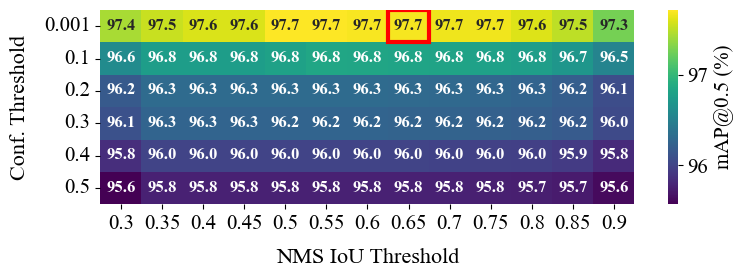

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# --- 1. Set Font Configuration ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

# --- 2. Data Preparation ---
data = [
    # Conf 0.001
    [0.001, 0.3, 97.4339], [0.001, 0.35, 97.5396], [0.001, 0.4, 97.5935], [0.001, 0.45, 97.5987],
    [0.001, 0.5, 97.7191], [0.001, 0.55, 97.7119], [0.001, 0.6, 97.7012], [0.001, 0.65, 97.6920],
    [0.001, 0.7, 97.6660], [0.001, 0.75, 97.6686], [0.001, 0.8, 97.6078], [0.001, 0.85, 97.5003], [0.001, 0.9, 97.2706],

    # Conf 0.1
    [0.1, 0.3, 96.5946], [0.1, 0.35, 96.7563], [0.1, 0.4, 96.7563], [0.1, 0.45, 96.7548],
    [0.1, 0.5, 96.7965], [0.1, 0.55, 96.8379], [0.1, 0.6, 96.8337], [0.1, 0.65, 96.8258],
    [0.1, 0.7, 96.8172], [0.1, 0.75, 96.7907], [0.1, 0.8, 96.7603], [0.1, 0.85, 96.6927], [0.1, 0.9, 96.5325],

    # Conf 0.2
    [0.2, 0.3, 96.1652], [0.2, 0.35, 96.3132], [0.2, 0.4, 96.3132], [0.2, 0.45, 96.3131],
    [0.2, 0.5, 96.3109], [0.2, 0.55, 96.3066], [0.2, 0.6, 96.3066], [0.2, 0.65, 96.2974],
    [0.2, 0.7, 96.2921], [0.2, 0.75, 96.2734], [0.2, 0.8, 96.2506], [0.2, 0.85, 96.2025], [0.2, 0.9, 96.0636],

    # Conf 0.3
    [0.3, 0.3, 96.0969], [0.3, 0.35, 96.2521], [0.3, 0.4, 96.2521], [0.3, 0.45, 96.2521],
    [0.3, 0.5, 96.2498], [0.3, 0.55, 96.2498], [0.3, 0.6, 96.2498], [0.3, 0.65, 96.2443],
    [0.3, 0.7, 96.2409], [0.3, 0.75, 96.2280], [0.3, 0.8, 96.2090], [0.3, 0.85, 96.1765], [0.3, 0.9, 96.0476],

    # Conf 0.4
    [0.4, 0.3, 95.8468], [0.4, 0.35, 95.9987], [0.4, 0.4, 95.9987], [0.4, 0.45, 95.9986],
    [0.4, 0.5, 95.9986], [0.4, 0.55, 95.9986], [0.4, 0.6, 95.9986], [0.4, 0.65, 95.9958],
    [0.4, 0.7, 95.9925], [0.4, 0.75, 95.9850], [0.4, 0.8, 95.9687], [0.4, 0.85, 95.9403], [0.4, 0.9, 95.8197],

    # Conf 0.5
    [0.5, 0.3, 95.5644], [0.5, 0.35, 95.7642], [0.5, 0.4, 95.7642], [0.5, 0.45, 95.7642],
    [0.5, 0.5, 95.7642], [0.5, 0.55, 95.7642], [0.5, 0.6, 95.7642], [0.5, 0.65, 95.7642],
    [0.5, 0.7, 95.7642], [0.5, 0.75, 95.7567], [0.5, 0.8, 95.7466], [0.5, 0.85, 95.7214], [0.5, 0.9, 95.6206]
]

df = pd.DataFrame(data, columns=['Conf', 'IoU', 'mAP'])
pivot_table = df.pivot(index="Conf", columns="IoU", values="mAP")

# --- 3. Plotting ---
plt.figure(figsize=(8, 3))

# Heatmap
ax = sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="viridis", 
                 cbar_kws={'label': 'mAP@0.5 (%)'}, 
                 annot_kws={"size": 12, "weight": "bold"}) 

# Highlight Peak Operating Point (Conf=0.001, IoU=0.5)
target_conf = 0.001
target_iou = 0.65  # <--- Changed to 0.5

if target_conf in pivot_table.index and target_iou in pivot_table.columns:
    row_idx = pivot_table.index.get_loc(target_conf)
    col_idx = pivot_table.columns.get_loc(target_iou)
    # Red Box
    rect = patches.Rectangle((col_idx, row_idx), 1, 1, linewidth=3, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

# Text Styling
# plt.title("Post-Processing Sensitivity Scan: mAP@0.5 (%)", fontsize=18, fontweight='bold', pad=15)
plt.xlabel("NMS IoU Threshold", fontsize=16, labelpad=10)
plt.ylabel("Conf. Threshold", fontsize=16, labelpad=10)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_label('mAP@0.5 (%)', size=15)

plt.tight_layout()
plt.savefig("fig_nms_scan_peak_05.pdf")
plt.show()

Starting Recall Sweep (Fixed IoU=0.65)...
Testing Conf=0.001... -> Recall: 0.9380 | Precision: 0.9480
Testing Conf=0.005... -> Recall: 0.9380 | Precision: 0.9480
Testing Conf=0.01... -> Recall: 0.9380 | Precision: 0.9480
Testing Conf=0.05... -> Recall: 0.9380 | Precision: 0.9480
Testing Conf=0.1... -> Recall: 0.9380 | Precision: 0.9480
Testing Conf=0.2... -> Recall: 0.9380 | Precision: 0.9480
Testing Conf=0.3... -> Recall: 0.9380 | Precision: 0.9480
Testing Conf=0.4... -> Recall: 0.9380 | Precision: 0.9480
Testing Conf=0.5... -> Recall: 0.9380 | Precision: 0.9470
Testing Conf=0.6... -> Recall: 0.9280 | Precision: 0.9520
Testing Conf=0.7... -> Recall: 0.9130 | Precision: 0.9600
Testing Conf=0.8... -> Recall: 0.8730 | Precision: 0.9690


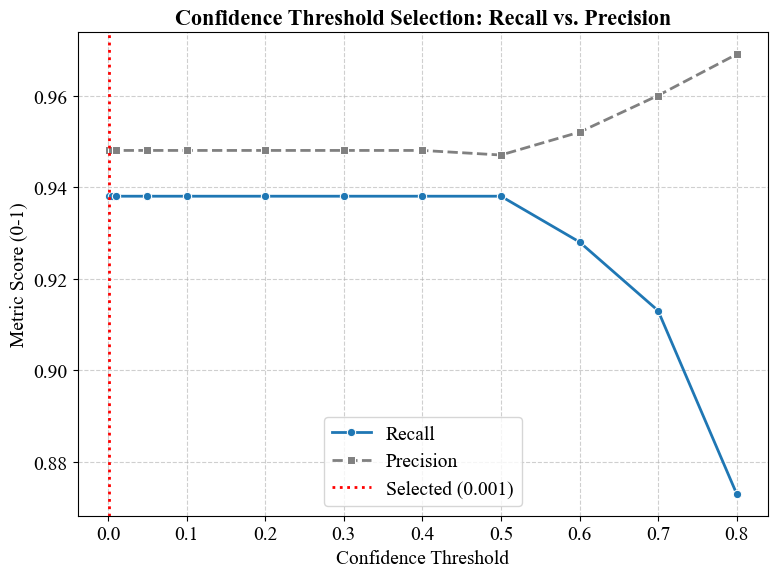


Saved figure to 'fig_conf_sweep.pdf'
     Conf  Recall  Precision
0   0.001   0.938      0.948
1   0.005   0.938      0.948
2   0.010   0.938      0.948
3   0.050   0.938      0.948
4   0.100   0.938      0.948
5   0.200   0.938      0.948
6   0.300   0.938      0.948
7   0.400   0.938      0.948
8   0.500   0.938      0.947
9   0.600   0.928      0.952
10  0.700   0.913      0.960
11  0.800   0.873      0.969


In [28]:
import subprocess
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# --- Configuration ---
weights_path = 'results_T_ITS_2026/Euljiro/1_2_2_Euljiro_off_peak_balanced_TrainVal_gelan-c_seed0/weights/last.pt'
data_yaml = 'data/udp_euljiro_bal_TrainVal.yaml'
img_size = 320 

# Fixed IoU (Your best result)
fixed_iou = 0.65

# Sweep Confidence from extremely low to high
# We focus heavily on the low end (0.001 to 0.1) because that's where recall drops
conf_thresholds = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

results = []

print(f"Starting Recall Sweep (Fixed IoU={fixed_iou})...")

# Function to clean output
def remove_ansi_codes(text):
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    return ansi_escape.sub('', text)

for conf in conf_thresholds:
    print(f"Testing Conf={conf}...", end=" ", flush=True)
    
    cmd = [
        "python", "val.py",
        "--data", data_yaml,
        "--weights", weights_path,
        "--img", str(img_size),
        "--conf", str(conf),
        "--iou", str(fixed_iou),
        "--task", "val",
        "--exist-ok",
        "--verbose"
    ]
    
    try:
        process = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        clean_output = remove_ansi_codes(process.stdout + "\n" + process.stderr)
        
        # Regex to find the "All" class line. 
        # YOLOv9 Output Columns: Class | Images | Instances | P | R | mAP50 | mAP50-95
        # We want "R" (Recall), which is the 5th column (index 4 in 0-based regex)
        # Pattern looks for: all   100     500    0.98    0.99    ...
        match = re.search(r'all\s+(\d+)\s+(\d+)\s+([0-9.]+)\s+([0-9.]+)\s+([0-9.]+)', clean_output)
        
        if match:
            recall = float(match.group(4)) # Group 4 is Recall (R)
            precision = float(match.group(3)) # Group 3 is Precision (P)
            results.append({'Conf': conf, 'Recall': recall, 'Precision': precision})
            print(f"-> Recall: {recall:.4f} | Precision: {precision:.4f}")
        else:
            print("-> [Failed to parse]")

    except Exception as e:
        print(f"-> [Error: {e}]")

# --- Plotting the Curve ---
if results:
    df = pd.DataFrame(results)
    
    # Set Font to Times New Roman
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['font.size'] = 14

    plt.figure(figsize=(8, 6))
    
    # Plot Recall Curve
    sns.lineplot(data=df, x='Conf', y='Recall', marker='o', linewidth=2, label='Recall')
    # Optional: Plot Precision to show the trade-off
    sns.lineplot(data=df, x='Conf', y='Precision', marker='s', linewidth=2, linestyle='--', color='grey', label='Precision')

    # Add a vertical line at your chosen 0.001 to show why you picked it
    plt.axvline(x=0.001, color='red', linestyle=':', linewidth=2, label='Selected (0.001)')

    plt.title("Confidence Threshold Selection: Recall vs. Precision", fontsize=16, fontweight='bold')
    plt.xlabel("Confidence Threshold", fontsize=14)
    plt.ylabel("Metric Score (0-1)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig("fig_conf_sweep.pdf")
    plt.show()
    print("\nSaved figure to 'fig_conf_sweep.pdf'")
    print(df)

## Yolo v9 2 class test.

In [1]:
import pandas as pd
import os
import numpy as np

# List of your 5 result file paths
files = [
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed0/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed1/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed2/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed3/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed4/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed5/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed6/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed7/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed8/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed9/results.csv",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed10/results.csv",
]

map50_values = []
map5095_values = []

print(f"{'Seed':<5} | {'mAP@0.5':<10} | {'mAP@0.5:0.95':<15}")
print("-" * 35)

for seed, file_path in enumerate(files):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    try:
        # Read the CSV
        df = pd.read_csv(file_path)
        
        # Clean column names (remove leading/trailing spaces common in YOLO logs)
        df.columns = df.columns.str.strip()
        
        # Get the row for epoch 49
        # (Assuming the epoch column is 0-indexed, so 49 is the 50th epoch)
        row = df[df['epoch'] == 49]
        
        if not row.empty:
            # Extract values
            map50 = row['metrics/mAP_0.5'].values[0]
            map5095 = row['metrics/mAP_0.5:0.95'].values[0]
            
            map50_values.append(map50)
            map5095_values.append(map5095)
            
            print(f"{seed:<5} | {map50:.5f}    | {map5095:.5f}")
        else:
            print(f"{seed:<5} | Epoch 49 not found in file")
            
    except Exception as e:
        print(f"Error reading seed {seed}: {e}")

print("-" * 35)

# Calculate Statistics
if map50_values:
    mean_50 = np.mean(map50_values)
    std_50 = np.std(map50_values, ddof=1) # ddof=1 for sample std dev
    
    mean_5095 = np.mean(map5095_values)
    std_5095 = np.std(map5095_values, ddof=1)

    print(f"Average mAP@0.5      : {mean_50:.5f} ± {std_50:.5f}")
    print(f"Average mAP@0.5:0.95 : {mean_5095:.5f} ± {std_5095:.5f}")
else:
    print("No data collected.")

Seed  | mAP@0.5    | mAP@0.5:0.95   
-----------------------------------
0     | 0.97901    | 0.86337
1     | 0.97792    | 0.86132
2     | 0.98124    | 0.86414
3     | 0.98037    | 0.86295
4     | 0.97789    | 0.85810
5     | 0.98378    | 0.86427
6     | 0.98001    | 0.85830
7     | 0.98065    | 0.86201
8     | 0.98189    | 0.86262
9     | 0.98253    | 0.86654
10    | 0.98002    | 0.86144
-----------------------------------
Average mAP@0.5      : 0.98048 ± 0.00183
Average mAP@0.5:0.95 : 0.86228 ± 0.00250


## finding D class mAP

In [7]:
import subprocess
import re
import os
import numpy as np

# --- CONFIGURATION ---
data_yaml = "data/udp_euljiro_bal_2class_TrainVal.yaml"

weight_files = [
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed0/weights/last.pt",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed1/weights/last.pt",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed2/weights/last.pt",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed3/weights/last.pt",
    "runs/train/v9_320_2class_gelan-c_TrainVal_epoch49_seed4/weights/last.pt"
]

def remove_ansi_codes(text):
    """Removes terminal color codes from output"""
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    return ansi_escape.sub('', text)

descend_map50 = []
descend_map5095 = []

# Table Header
print(f"{'Seed':<5} | {'mAP@50 (Class D)':<20} | {'mAP@50-95 (Class D)':<20}")
print("-" * 55)

for i, weight_path in enumerate(weight_files):
    if not os.path.exists(weight_path):
        print(f"{i:<5} | File not found")
        continue

    # Run validation
    cmd = [
        "python", "val.py",
        "--data", data_yaml,
        "--weights", weight_path,
        "--task", "val",
        "--verbose"
    ]

    try:
        result = subprocess.run(cmd, capture_output=True, text=True)
        # Combine stdout and stderr just in case
        full_output = result.stdout + "\n" + result.stderr
        
        # Clean the output
        clean_output = remove_ansi_codes(full_output)
        
        found = False
        for line in clean_output.splitlines():
            parts = line.split()
            
            # Check for the "D" class line
            # Standard columns: Class | Images | Instances | P | R | mAP50 | mAP50-95
            if len(parts) >= 7 and parts[0] == 'D':
                try:
                    map50 = float(parts[5])
                    map5095 = float(parts[6])
                    
                    descend_map50.append(map50)
                    descend_map5095.append(map5095)
                    
                    print(f"{i:<5} | {map50:.5f}              | {map5095:.5f}")
                    found = True
                    break
                except ValueError:
                    continue 
        
        if not found:
            print(f"{i:<5} | Class 'D' not found.")

    except Exception as e:
        print(f"{i:<5} | Error: {e}")

print("-" * 55)

# Calculate Statistics
if descend_map50:
    mean_50 = np.mean(descend_map50)
    std_50 = np.std(descend_map50, ddof=1) # ddof=1 for sample standard deviation
    
    mean_5095 = np.mean(descend_map5095)
    std_5095 = np.std(descend_map5095, ddof=1)
    
    print(f"Average 'D' mAP@50      : {mean_50:.5f} ± {std_50:.5f}")
    print(f"Average 'D' mAP@50-95   : {mean_5095:.5f} ± {std_5095:.5f}")
else:
    print("No data extracted.")

Seed  | mAP@50 (Class D)     | mAP@50-95 (Class D) 
-------------------------------------------------------
0     | 0.97600              | 0.80200
1     | 0.97800              | 0.81500
2     | 0.98000              | 0.80300
3     | 0.97400              | 0.80400
4     | 0.97500              | 0.81800
-------------------------------------------------------
Average 'D' mAP@50      : 0.97660 ± 0.00241
Average 'D' mAP@50-95   : 0.80840 ± 0.00750
